# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

<br>Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание данных

In [1]:
import pandas as pd
from datetime import datetime
from scipy import stats as st
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<b>Таблица users (информация о пользователях):</b>
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана<br>
<b>Таблица calls (информация о звонках):</b>
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок<br>
<b>Таблица messages (информация о сообщениях):</b>
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение<br>
<b>Таблица internet (информация об интернет-сессиях):</b>
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя<br>
<b>Таблица tariffs (информация о тарифах):</b>
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [2]:
try:
    calls = pd.read_csv('datasets/calls.csv')
    internet = pd.read_csv('datasets/internet.csv')
    messages = pd.read_csv('datasets/messages.csv')
    tariffs = pd.read_csv('datasets/tariffs.csv')
    users = pd.read_csv('datasets/users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

In [3]:
for dataframe in [calls, messages, internet, tariffs, users]:
    print()
    display(dataframe.info())
    display(dataframe.head())
    display(dataframe[dataframe.duplicated()])
    print('\n\n')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,call_date,duration,user_id






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,message_date,user_id






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,id,mb_used,session_date,user_id






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


## Вывод

* Мы имеем 5 разных датасета с персональными данными абонентов (500 строк), их звонками (202607), сообщениями (123036 сообщения) и трафиком (149396 строк), а также условия тарифа (2 строки).<br>
* В датасетах 'calls' минуты представлены в десятичной системе - наверное можно было бы их преобразовать к секундам, но проще округлить в сторону повышения, как это делает оператор. Также можно поступить с 'mb_used' в 'internet' - килобайты, которые сохранены в виде дроби, имеют мало значение при изменерии трафика в тысячи мегабайт.<br>
* Во всех датасетах даты представлены в виде строки - надо перевести в datetime.<br>
* Есть странная колонка 'unnamed' в 'internet', которая дублирует индексы - её можно удалить.<br>
* С первого взгляда пропуски есть только в 'churn_date' в таблице 'users', которые должны быть обусловлены тем, что пользователи ещё пользуются тарифом.
* Дубликатов в данных не обнаружено<br>

# Подготовка данных

## Привидение к нужному типу данных

In [4]:
calls_without_missed = calls.query('duration != 0.0')

In [5]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [6]:
calls_without_missed.describe()

,duration,user_id
count,162994.000000,162994.000000
mean,8.397794,1254.149877
std,5.353022,144.751050
min,0.010000,1000.000000
25%,4.170000,1126.000000
50%,7.740000,1261.000000
75%,11.850000,1379.000000
max,38.000000,1499.000000


Звонков с нулевой длительностью почти 40 тысяч или около 20%. Они значительно влияют на среднее и медиану. Скорее всего, это входящие или исходящие пропущенные звонки. На такие звонки не должен тратиться тарифный лимит, поэтому можем их не учитывать.

Округлим в сторону повышения минуты

In [7]:
calls_without_missed['duration'] = calls_without_missed['duration'].apply(np.ceil).astype('int64')

In [8]:
calls_without_missed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         162994 non-null  object
 1   call_date  162994 non-null  object
 2   duration   162994 non-null  int64 
 3   user_id    162994 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.2+ MB


In [9]:
calls_without_missed.describe()

,duration,user_id
count,162994.000000,162994.000000
mean,8.897880,1254.149877
std,5.353761,144.751050
min,1.000000,1000.000000
25%,5.000000,1126.000000
50%,8.000000,1261.000000
75%,12.000000,1379.000000
max,38.000000,1499.000000


Удалим несодержательную (дублирующую индексы) колонку 'Unnamed: 0'

In [10]:
internet = internet.drop('Unnamed: 0', 1)

In [11]:
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [13]:
internet_without_null = internet.query('mb_used != 0.0')

In [14]:
internet_without_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            129798 non-null  object 
 1   mb_used       129798 non-null  float64
 2   session_date  129798 non-null  object 
 3   user_id       129798 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.0+ MB


Примерно 20 тысяч использований трафика были нулевыми. Возможно это моменты подключения к сети после выхода из авиарежима. Можем не использовать эти значения.

Округлим оставшиеся значения в большую сторону, как это делает оператор

In [15]:
internet_without_null['mb_used'] = np.ceil(internet_without_null['mb_used']).astype(int)

In [16]:
for data in [tariffs, messages, calls_without_missed, internet_without_null, users]:
    print(data.head(5))

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
       id   call_date  duration  user_id
2  1000_2  2018-06-11         3     1000
3  1000_3  2018-09-21        14     1000
4  1000_4  2018-12-15         6     1000
7  1000_7  2018-08-22        19     1000
8  1000_8  2018-09-15        19     1000
       id  mb_used session_date  user_id
0  1000_0      113   2018-11-25     1000
1  1000_1     1053   2018-09-07     1000
2  1000_2

Переведем во всех датасетах даты в формат datetime, чтобы с ними можно было работать

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
calls_without_missed['call_date'] = pd.to_datetime(calls_without_missed['call_date'], format='%Y-%m-%d')
internet_without_null['session_date'] = pd.to_datetime(internet_without_null['session_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [18]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

## Исправление ошибок в данных

В 'churn_date' много пропусков - данные ограничены 2018 годом, скорее всего эти абоненты не меняли тариф в этом году. Заполним пропуски 1 января 2019 года, чтобы в колонке 'active_days' высчитать, сколько дней в год они пользовались тарифом.

In [19]:
first_day_2019 = datetime.strptime("2019-01-01", "%Y-%m-%d")
first_day_2019

datetime.datetime(2019, 1, 1, 0, 0)

In [20]:
def active_days(row):
    if pd.isna(row['churn_date']):
        return (first_day_2019 - row['reg_date']).days
    else:
        return (row['churn_date'] - row['reg_date']).days

In [21]:
def actual_churn_date(row):
    if pd.isna(row['churn_date']):
        return first_day_2019
    return row['churn_date']

In [22]:
users['churn_date'] = users.apply(actual_churn_date, axis=1)

In [23]:
users['active_days'] = users.apply(active_days, axis=1)

In [24]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart,61
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,198
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra,137
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,232
...,...,...,...,...,...,...,...,...,...
495,1495,65,2019-01-01,Иркутск,Авксентий,Фокин,2018-08-28,ultra,126
496,1496,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart,339
497,1497,32,2019-01-01,Челябинск,Каролина,Агеева,2018-10-09,smart,84
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,98


Добавим столбец с месяцем использования звонков, сообщений и интернета, чтобы было возможно получить статистику по месяцам

In [25]:
calls_without_missed['month'] = calls_without_missed['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet_without_null['month'] = internet_without_null['session_date'].dt.month

Подсчитаем количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам. Для этого напишем функцию, которая сортирует значения по месяцу, группирует по id и месяцу и затем агрегирует по предложенным метрикам

In [26]:
def spending_aggregetion(df, col, methods):
    df = df.sort_values(by='month').groupby(['user_id', 'month']).agg({col: methods}).reset_index()
    return df

In [27]:
calls_without_missed = spending_aggregetion(calls_without_missed, 'duration', ['count', 'sum', 'mean', 'median'])

In [28]:
calls_without_missed.head()

user_id month duration                       
                   count  sum       mean median
0    1000     5       17  159   9.352941    9.0
1    1000     6       28  172   6.142857    5.0
2    1000     7       41  340   8.292683    8.0
3    1000     8       42  408   9.714286    8.5
4    1000     9       46  466  10.130435    9.0

In [29]:
messages = spending_aggregetion(messages, 'message_date', 'count')
messages.head()

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [30]:
internet_without_null = spending_aggregetion(internet_without_null, 'mb_used', ['sum', 'mean', 'median'])
internet_without_null.head()

user_id month mb_used                   
                    sum        mean median
0    1000     5    2256  564.000000  587.0
1    1000     6   23257  528.568182  501.0
2    1000     7   14016  500.571429  520.5
3    1000     8   14070  521.111111  522.0
4    1000     9   14581  583.240000  548.0

Поменяем название колонки "tariff_name" на "tariff", чтобы было удобнее мёржить с другими таблицами

In [31]:
tariffs = tariffs.rename(columns={"tariff_name": "tariff"})
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Смёржим таблицы по общим колонкам 'user_id', 'month'.

In [32]:
total_consumption = messages.merge(calls_without_missed, on=['user_id', 'month'], how='outer')

In [33]:
total_consumption = total_consumption.merge(internet_without_null, on=['user_id', 'month'], how='outer')

In [34]:
total_consumption = users.merge(total_consumption, on='user_id', how='outer')

In [35]:
total_consumption = total_consumption.merge(tariffs, on='tariff', how='outer')

In [36]:
total_consumption

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_date,"(duration, count)","(duration, sum)","(duration, mean)","(duration, median)","(mb_used, sum)","(mb_used, mean)","(mb_used, median)",messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,5.0,22.0,17.0,159.0,9.352941,9.0,2256.0,564.000000,587.0,1000,30720,3000,1950,150,1,1
1,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,6.0,60.0,28.0,172.0,6.142857,5.0,23257.0,528.568182,501.0,1000,30720,3000,1950,150,1,1
2,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,7.0,75.0,41.0,340.0,8.292683,8.0,14016.0,500.571429,520.5,1000,30720,3000,1950,150,1,1
3,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,8.0,81.0,42.0,408.0,9.714286,8.5,14070.0,521.111111,522.0,1000,30720,3000,1950,150,1,1
4,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,9.0,57.0,46.0,466.0,10.130435,9.0,14581.0,583.240000,548.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,98,10.0,42.0,30.0,247.0,8.233333,9.0,20604.0,420.489796,431.0,50,15360,500,550,200,3,3
3212,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,9.0,11.0,8.0,70.0,8.750000,6.5,1848.0,462.000000,351.0,50,15360,500,550,200,3,3
3213,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,10.0,48.0,44.0,449.0,10.204545,9.0,17809.0,414.162791,319.0,50,15360,500,550,200,3,3
3214,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,11.0,59.0,62.0,612.0,9.870968,10.0,17984.0,461.128205,418.0,50,15360,500,550,200,3,3


In [37]:
#не сработало, пришлось задавать все названия списоком
total_consumption.rename(columns={"('duration', 'count')": "duration_count", "('duration', 'sum')": "duration_sum",
                                            "('duration', 'mean')": "duration_mean", "('duration', 'median')": "duration_median",
                                            "('mb_used', 'sum')": "mb_used_sum", "('mb_used', 'mean')": "mb_used_mean",
                                             "('mb_used', 'median')": "mb_used_median"})

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_date,"(duration, count)","(duration, sum)","(duration, mean)","(duration, median)","(mb_used, sum)","(mb_used, mean)","(mb_used, median)",messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,5.0,22.0,17.0,159.0,9.352941,9.0,2256.0,564.000000,587.0,1000,30720,3000,1950,150,1,1
1,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,6.0,60.0,28.0,172.0,6.142857,5.0,23257.0,528.568182,501.0,1000,30720,3000,1950,150,1,1
2,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,7.0,75.0,41.0,340.0,8.292683,8.0,14016.0,500.571429,520.5,1000,30720,3000,1950,150,1,1
3,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,8.0,81.0,42.0,408.0,9.714286,8.5,14070.0,521.111111,522.0,1000,30720,3000,1950,150,1,1
4,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,9.0,57.0,46.0,466.0,10.130435,9.0,14581.0,583.240000,548.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,98,10.0,42.0,30.0,247.0,8.233333,9.0,20604.0,420.489796,431.0,50,15360,500,550,200,3,3
3212,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,9.0,11.0,8.0,70.0,8.750000,6.5,1848.0,462.000000,351.0,50,15360,500,550,200,3,3
3213,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,10.0,48.0,44.0,449.0,10.204545,9.0,17809.0,414.162791,319.0,50,15360,500,550,200,3,3
3214,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,11.0,59.0,62.0,612.0,9.870968,10.0,17984.0,461.128205,418.0,50,15360,500,550,200,3,3


In [38]:
total_consumption.columns = ['user_id', 'age', 'churn_date', 'city', 'first_name','last_name','reg_date','tariff',
                             'active_days','month','message_sum', "duration_count", "duration_sum", "duration_mean", 
                             "duration_median", "mb_used_sum", "mb_used_mean", "mb_used_median", 'messages_included',
                             'mb_per_month_included', 'minutes_included','rub_monthly_fee', 'rub_per_gb','rub_per_message',
                             'rub_per_minute']

In [39]:
total_consumption

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_sum,duration_count,duration_sum,duration_mean,duration_median,mb_used_sum,mb_used_mean,mb_used_median,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,5.0,22.0,17.0,159.0,9.352941,9.0,2256.0,564.000000,587.0,1000,30720,3000,1950,150,1,1
1,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,6.0,60.0,28.0,172.0,6.142857,5.0,23257.0,528.568182,501.0,1000,30720,3000,1950,150,1,1
2,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,7.0,75.0,41.0,340.0,8.292683,8.0,14016.0,500.571429,520.5,1000,30720,3000,1950,150,1,1
3,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,8.0,81.0,42.0,408.0,9.714286,8.5,14070.0,521.111111,522.0,1000,30720,3000,1950,150,1,1
4,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,9.0,57.0,46.0,466.0,10.130435,9.0,14581.0,583.240000,548.0,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,98,10.0,42.0,30.0,247.0,8.233333,9.0,20604.0,420.489796,431.0,50,15360,500,550,200,3,3
3212,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,9.0,11.0,8.0,70.0,8.750000,6.5,1848.0,462.000000,351.0,50,15360,500,550,200,3,3
3213,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,10.0,48.0,44.0,449.0,10.204545,9.0,17809.0,414.162791,319.0,50,15360,500,550,200,3,3
3214,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,11.0,59.0,62.0,612.0,9.870968,10.0,17984.0,461.128205,418.0,50,15360,500,550,200,3,3


In [40]:
total_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             3216 non-null   datetime64[ns]
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   active_days            3216 non-null   int64         
 9   month                  3214 non-null   float64       
 10  message_sum            2717 non-null   float64       
 11  duration_count         3168 non-null   float64       
 12  duration_sum           3168 non-null   float64       
 13  dur

In [41]:
total_consumption[total_consumption['month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_sum,duration_count,duration_sum,duration_mean,duration_median,mb_used_sum,mb_used_mean,mb_used_median,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
243,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1
2619,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,15360,500,550,200,3,3


In [42]:
#две строки с отсутствующим месяцем были людьми, зарегистрированные в декабре
total_consumption['month'] = total_consumption['month'].fillna(12)

Кажется, отсутствующие строки - это люди, которые не пользовались тем или иным видом услуг в обозначенные месяцы. Заполним пропуски нулями.

In [43]:
display(total_consumption[total_consumption['duration_sum'].isna()])
print()
display(calls[calls['user_id'] == 1091])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_sum,duration_count,duration_sum,duration_mean,duration_median,mb_used_sum,mb_used_mean,mb_used_median,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
151,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,5.0,30.0,NaN,NaN,NaN,NaN,10714.0,487.000000,454.5,1000,30720,3000,1950,150,1,1
152,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,6.0,30.0,NaN,NaN,NaN,NaN,10245.0,569.166667,474.5,1000,30720,3000,1950,150,1,1
153,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,7.0,35.0,NaN,NaN,NaN,NaN,16460.0,548.666667,532.5,1000,30720,3000,1950,150,1,1
154,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,8.0,31.0,NaN,NaN,NaN,NaN,12644.0,574.727273,582.0,1000,30720,3000,1950,150,1,1
155,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,9.0,32.0,NaN,NaN,NaN,NaN,16611.0,615.222222,609.0,1000,30720,3000,1950,150,1,1
156,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,10.0,44.0,NaN,NaN,NaN,NaN,15659.0,559.250000,610.5,1000,30720,3000,1950,150,1,1
157,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,11.0,28.0,NaN,NaN,NaN,NaN,11876.0,539.818182,491.5,1000,30720,3000,1950,150,1,1
158,1091,36,2019-01-01,Набережные Челны,Вера,Суслова,2018-05-08,ultra,238,12.0,42.0,NaN,NaN,NaN,NaN,13292.0,492.296296,520.0,1000,30720,3000,1950,150,1,1
204,1106,67,2019-01-01,Калуга,Исаак,Костин,2018-04-26,ultra,250,4.0,9.0,NaN,NaN,NaN,NaN,2925.0,731.250000,693.0,1000,30720,3000,1950,150,1,1
205,1106,67,2019-01-01,Калуга,Исаак,Костин,2018-04-26,ultra,250,5.0,28.0,NaN,NaN,NaN,NaN,16591.0,448.405405,460.0,1000,30720,3000,1950,150,1,1


,id,call_date,duration,user_id


In [44]:
total_consumption = total_consumption.fillna(0)
total_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   age                    3216 non-null   int64         
 2   churn_date             3216 non-null   datetime64[ns]
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   active_days            3216 non-null   int64         
 9   month                  3216 non-null   float64       
 10  message_sum            3216 non-null   float64       
 11  duration_count         3216 non-null   float64       
 12  duration_sum           3216 non-null   float64       
 13  dur

In [45]:
for col in ['month', 'message_sum', 'duration_count', 'duration_sum', 'mb_used_sum']:
    total_consumption[col] = total_consumption[col].astype('int64')

Напишем функцию, которая высчитывает выручку за месяц с каждого абонента

In [46]:
def monthly_income(row):
    total_revenue = row['rub_monthly_fee']
    calls_difference = row['duration_sum'] - row['minutes_included']
    message_difference = row['message_sum'] - row['messages_included']
    internet_difference = np.ceil(row['mb_used_sum'] - row['mb_per_month_included'])
    if calls_difference > 0:
        total_revenue += calls_difference * row['rub_per_minute']
    if message_difference > 0:
        total_revenue += message_difference * row['rub_per_message']
    if internet_difference > 0:
        total_revenue += np.ceil(internet_difference / 1024) * row['rub_per_gb']
    return total_revenue

In [47]:
total_consumption['monthly_income'] = total_consumption.apply(monthly_income, 1)

In [48]:
total_consumption

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,active_days,month,message_sum,duration_count,duration_sum,duration_mean,duration_median,mb_used_sum,mb_used_mean,mb_used_median,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,monthly_income
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,5,22,17,159,9.352941,9.0,2256,564.000000,587.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,6,60,28,172,6.142857,5.0,23257,528.568182,501.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,7,75,41,340,8.292683,8.0,14016,500.571429,520.5,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,8,81,42,408,9.714286,8.5,14070,521.111111,522.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,221,9,57,46,466,10.130435,9.0,14581,583.240000,548.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,98,10,42,30,247,8.233333,9.0,20604,420.489796,431.0,50,15360,500,550,200,3,3,1750.0
3212,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,9,11,8,70,8.750000,6.5,1848,462.000000,351.0,50,15360,500,550,200,3,3,550.0
3213,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,10,48,44,449,10.204545,9.0,17809,414.162791,319.0,50,15360,500,550,200,3,3,1150.0
3214,1499,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,96,11,59,62,612,9.870968,10.0,17984,461.128205,418.0,50,15360,500,550,200,3,3,1513.0


## Вывод

* Для удобства работы и вычисления новых значений колонки с датами были приведены к 'datetime', ряд значений был переведен и float в int. 
* Изначально пропусков в таблицах не было, они возникли при объединении таблиц и агрегации по id пользователя и месяцам, особенно в количестве сообщений за месяц. Проверка конкретных датасетов показала, что пропуски обсуловлены тем, что люди не пользовались этим услугами в тот месяц, что например с смсками объяснимо, что они постепенно заменяются сообщениями в мессенджерах, поэтому было принято решение заполнить пропуски нулями.

# Анализ данных

In [49]:
agg_funcs = ['mean', 'median', 'var', 'std']

Выделим в отдельные переменные данные с общим количеством потраченных минут, смс и траффика для каждого тарифа в отдельный датасет

In [50]:
ultra = total_consumption.query('tariff == "ultra"')[['user_id', 'month', 'duration_sum', 'mb_used_sum', 'message_sum']]
ultra

,user_id,month,duration_sum,mb_used_sum,message_sum
0,1000,5,159,2256,22
1,1000,6,172,23257,60
2,1000,7,340,14016,75
3,1000,8,408,14070,81
4,1000,9,466,14581,57
...,...,...,...,...,...
981,1495,8,92,2616,13
982,1495,9,813,33105,82
983,1495,10,1030,29393,82
984,1495,11,954,38972,79


In [51]:
smart = total_consumption.query('tariff == "smart"')[['user_id', 'month', 'duration_sum', 'mb_used_sum', 'message_sum']]
smart

,user_id,month,duration_sum,mb_used_sum,message_sum
986,1001,11,430,18452,0
987,1001,12,414,14053,0
988,1002,6,117,10871,4
989,1002,7,214,17601,11
990,1002,8,289,20347,13
...,...,...,...,...,...
3211,1498,10,247,20604,42
3212,1499,9,70,1848,11
3213,1499,10,449,17809,48
3214,1499,11,612,17984,59


Напишем функцию для создания гистограмы месячных трат пользователей с выделением тарифных лимитов

In [52]:
def hist_for_montly_spending(column, ultralimit, smartlimit, title):
    ultra[column].hist(alpha=.5, grid=True, label='ultra', color='red', bins=30, figsize=(12,6))
    smart[column].hist(alpha=.5, grid=True, label='smart', color='green', bins=30, figsize=(12,6))
    plt.axvline(ultralimit, color = 'orange', linestyle = '-.')
    plt.axvline(smartlimit, color = 'blue', linestyle = '-.')
    plt.legend(['ultra_limit', 'smart_limit', 'ultra', 'smart'], loc='upper center')
    plt.title(title)
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()

Заметно, что многим пользователям 'smart' не хватает предусмотренного тарифом лимита - большая часть пользователей либо его использует наполную, многие доплачивают за лишние 100-200 минут.<br>
У пользователей 'ultra' сценарии использования более разнообразные, но практически никто из них не 'выбирает' количество тарифных минут хотя бы наполовину.

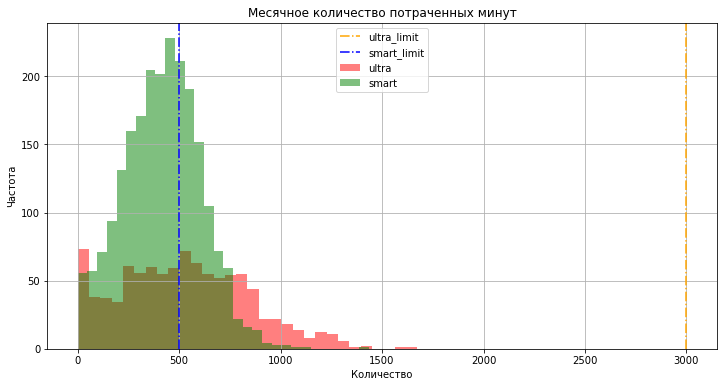

In [53]:
hist_for_montly_spending('duration_sum', 3000, 500, 'Месячное количество потраченных минут')

С смсками похожая картина, но в обоих тарифах многие их в принципе не используют, а пользователи 'ultra' в этот раз не используют потенциал тарифа и на 1/5.

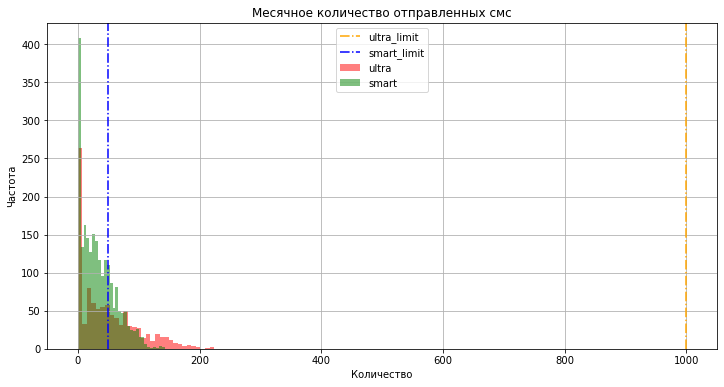

In [54]:
hist_for_montly_spending('message_sum', 1000, 50, 'Месячное количество отправленных смс')

С потреблением траффика интереснее - большей части пользователей 'smart' не хватает предоставленного лимита. Достаточно случаев, когда и пользователем 'ultra' не хватает траффика - стоит задуматься над увеличением лимита.

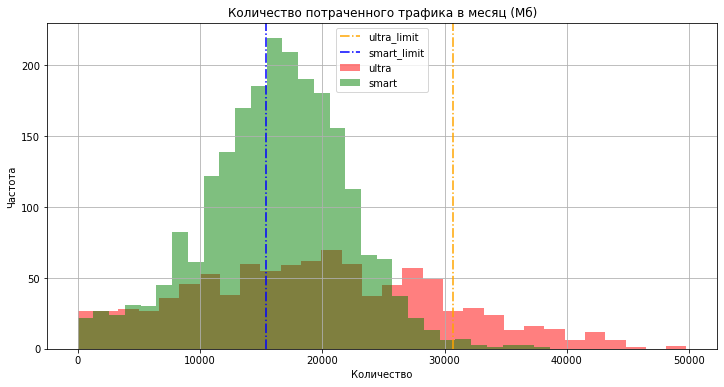

In [55]:
hist_for_montly_spending('mb_used_sum', 30720, 15360, 'Количество потраченного трафика в месяц (Мб)')

In [56]:
# Код ревьюера
display(smart[['mb_used_sum', 'message_sum', 'duration_sum']].describe())
display(ultra[['mb_used_sum', 'message_sum', 'duration_sum']].describe())

,mb_used_sum,message_sum,duration_sum
count,2230.000000,2230.000000,2230.000000
mean,16221.910762,33.369058,417.747534
std,5886.299627,28.230396,190.476754
min,0.000000,0.000000,0.000000
25%,12645.250000,10.000000,282.000000
50%,16529.000000,28.000000,421.500000
75%,20068.000000,51.000000,545.000000
max,38610.000000,143.000000,1435.000000


,mb_used_sum,message_sum,duration_sum
count,986.000000,986.000000,986.000000
mean,19467.137931,49.313387,526.089249
std,10110.255401,47.806040,317.887549
min,0.000000,0.000000,0.000000
25%,11761.000000,6.000000,282.500000
50%,19320.000000,38.000000,518.000000
75%,26860.250000,78.750000,751.750000
max,49789.000000,224.000000,1673.000000


По сравнению с ультра, в смарт находится больше выбросов - сказывается бОльшая скученность значений

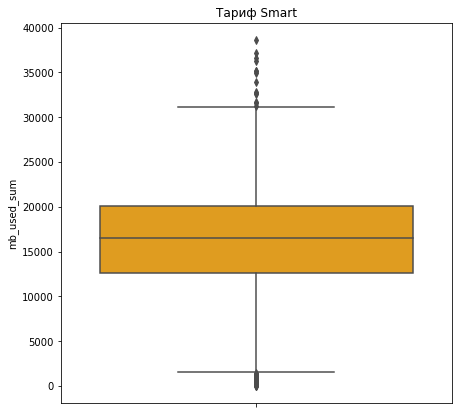

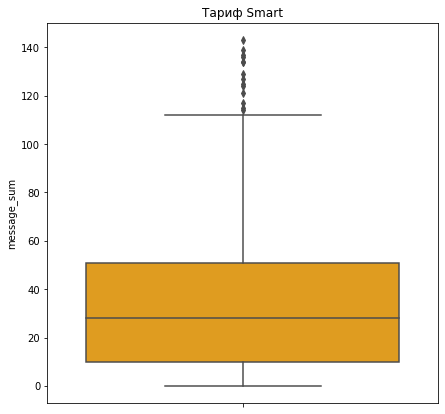

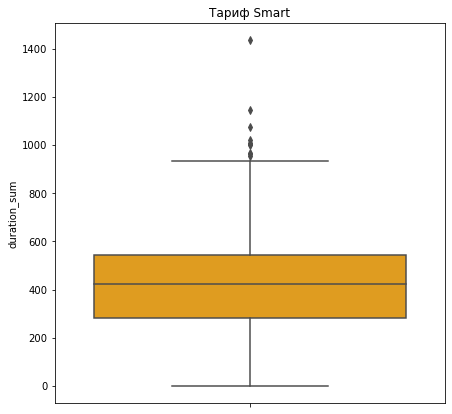

In [57]:
for column in ['mb_used_sum', 'message_sum', 'duration_sum']:
    fig, ax = plt.subplots()
    sns.boxplot(y=column, data=smart, color='orange').set_title('Тариф Smart')
    fig.set_size_inches(7,7)

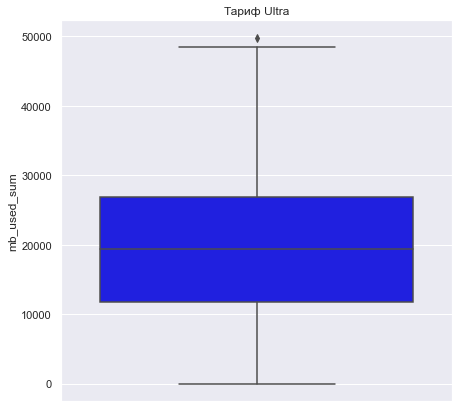

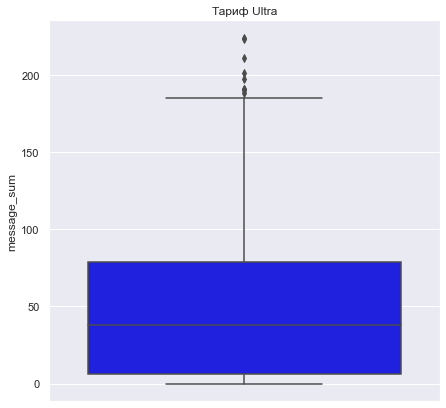

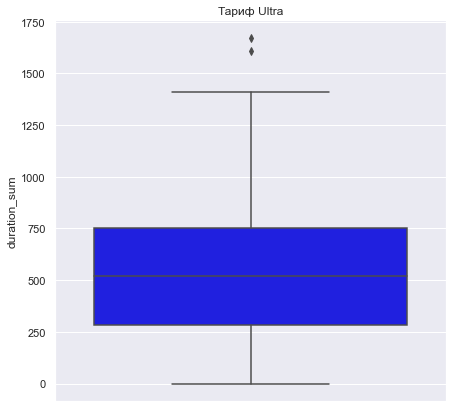

In [58]:
for column in ['mb_used_sum', 'message_sum', 'duration_sum']:
    sns.set()
    fig, ax = plt.subplots()
    sns.boxplot(y=column, data=ultra, color='blue').set_title('Тариф Ultra')
    fig.set_size_inches(7,7)

Добавим к статистикам из describe() среднее и дисперсию

In [59]:
consumption_by_month_ultra = (ultra.groupby(['month'])
                        .agg({'duration_sum': agg_funcs, 'mb_used_sum': agg_funcs, 'message_sum': agg_funcs}).round(2))

In [60]:
consumption_by_month_smart = (smart.groupby(['month'])
                        .agg({'duration_sum': agg_funcs, 'mb_used_sum': agg_funcs, 'message_sum': agg_funcs}).round(2))
consumption_by_month_smart

duration_sum                          mb_used_sum                        \
              mean median       var     std        mean   median          var   
month                                                                           
1           203.85  162.5  23787.34  154.23     8524.44   7107.0  41626212.80   
2           298.69  258.0  36412.29  190.82    11611.40  12572.5  39119349.33   
3           390.05  409.0  36823.16  191.89    15123.86  15690.0  34052595.02   
4           367.13  368.5  34778.21  186.49    13479.48  14104.5  32547357.19   
5           387.36  433.0  34820.06  186.60    15825.20  16343.0  35822355.43   
6           395.64  400.0  30742.92  175.34    15814.77  16095.5  33616415.17   
7           408.35  414.0  32250.27  179.58    15763.51  15948.0  34861096.71   
8           421.47  432.0  34793.58  186.53    16632.17  16855.0  31363516.97   
9           428.61  435.0  33535.34  183.13    16324.53  16050.0  27062146.44   
10          426.14  427.5  35392.34  188.13    16778.56  17248.5  34417112.47   
11          435.27  428.5  31605.24  177.78    16917.53  17036.5  28588524.42   
12          477.14  471.0  40258.40  200.64    18083.17  17697.0  32021636.50   

               message_sum                        
           std        mean median     var    std  
month                                             
1      6451.84       18.24     15  262.37  16.20  
2      6254.55       24.09     20  473.10  21.75  
3      5835.46       31.86     23  718.49  26.80  
4      5705.03       30.74     28  602.14  24.54  
5      5985.18       33.77     30  730.99  27.04  
6      5797.97       33.40     28  806.81  28.40  
7      5904.33       33.75     29  799.89  28.28  
8      5600.31       33.64     27  838.26  28.95  
9      5202.13       33.64     30  790.62  28.12  
10     5866.61       33.77     30  816.11  28.57  
11     5346.82       34.08     28  805.94  28.39  
12     5658.77       35.89     29  936.01  30.59

Стандартное отклонение у тарифа ультра до двух раз больше, чем у смарта - люди используют его более разнообразно и менее предсказуемо, чем пользователи смарта, наверное из-за большей свободы манёвра в плане тарифных лимитов.

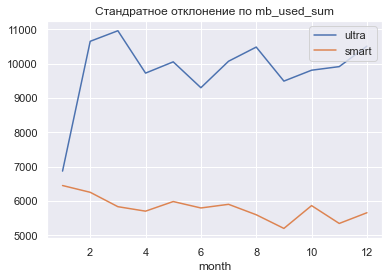

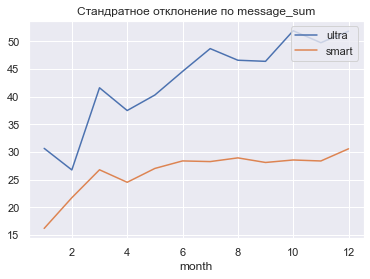

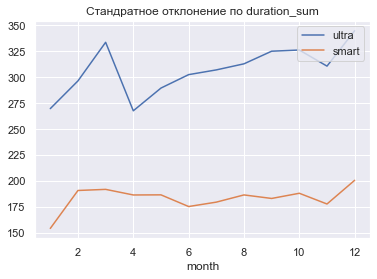

In [61]:
for col in ['mb_used_sum', 'message_sum', 'duration_sum']:
    fig, ax = plt.subplots()
    consumption_by_month_ultra[col]['std'].plot(title=f'Стандратное отклонение по {col}', legend=['ultra', 'smart'])
    consumption_by_month_smart[col]['std'].plot()
    plt.legend(['ultra', 'smart'], loc='upper right')

По дисперсии похожая картина, что понятно, ведь это квадрат отклонения, т.е. разница будет лишь чуть большей "крутизне" графиков

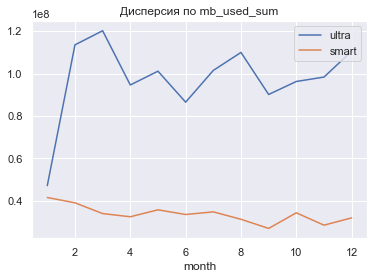

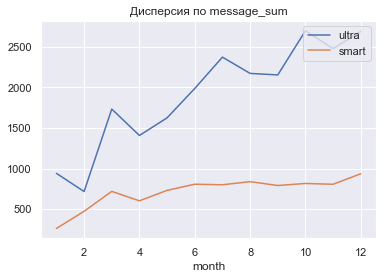

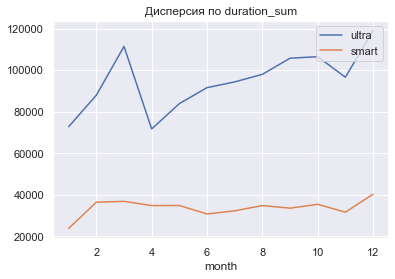

In [62]:
for col in ['mb_used_sum', 'message_sum', 'duration_sum']:
    fig, ax = plt.subplots()
    consumption_by_month_ultra[col]['var'].plot(title=f'Дисперсия по {col}')
    consumption_by_month_smart[col]['var'].plot()
    plt.legend(['ultra', 'smart'], loc='upper right')

По среднему получается интересная картина - у обоих тарифов потребление растёт к концу года, но ультра рост более резкий. Если в феврале у обоих тарифов среднее одинаковое, то к концу года пользователи ультра используют на 25-30% больше звонков и трафика и почти в 2 раза больше смс

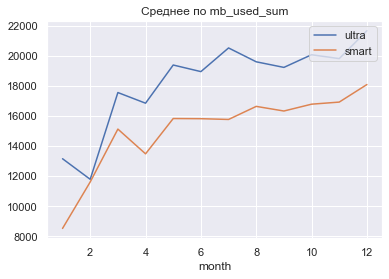

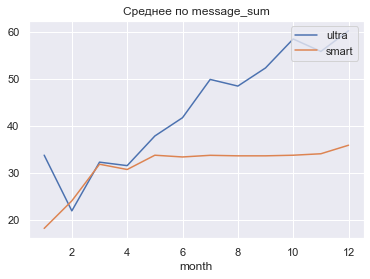

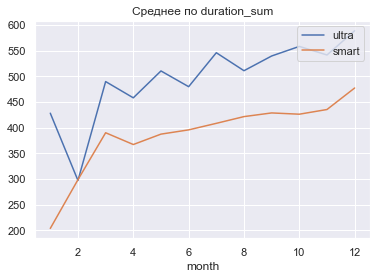

In [63]:
for col in ['mb_used_sum', 'message_sum', 'duration_sum']:
    fig, ax = plt.subplots()
    consumption_by_month_ultra[col]['mean'].plot(title=f'Среднее по {col}')
    consumption_by_month_smart[col]['mean'].plot()
    plt.legend(['ultra', 'smart'], loc='upper right')

In [64]:
for col in ['mb_used_sum', 'message_sum', 'duration_sum']:
    print()
    print(f'Общая дисперсия по {col} для тарифа Smart {smart[col].var()}')
    print(f'Общая дисперсия по {col} для тарифа Ultra {ultra[col].var()}')
    print()


Общая дисперсия по mb_used_sum для тарифа Smart 34648523.30069166
Общая дисперсия по mb_used_sum для тарифа Ultra 102217264.27537195


Общая дисперсия по message_sum для тарифа Smart 796.955255730113
Общая дисперсия по message_sum для тарифа Ultra 2285.4174246558414


Общая дисперсия по duration_sum для тарифа Smart 36281.39383644458
Общая дисперсия по duration_sum для тарифа Ultra 101052.49354928387



In [65]:
income_by_month_ultra = (total_consumption.query('tariff == "ultra"').groupby(['month'])
                        .agg({'monthly_income': agg_funcs}).round(2))

In [67]:
income_by_month_smart = (total_consumption.query('tariff == "smart"').groupby(['month'])
                        .agg({'monthly_income': agg_funcs}).round(2))

Заметно, что к концу года средние затраты пользователей Smart вырастают более чем в 2 раза, абонентам с этим тарифом не хватает пакета услуг и они значительно переплачивают за дополнительные минуты и интернет. Затраты же Ultra изменились мало и ненамного превышают плату за тариф.

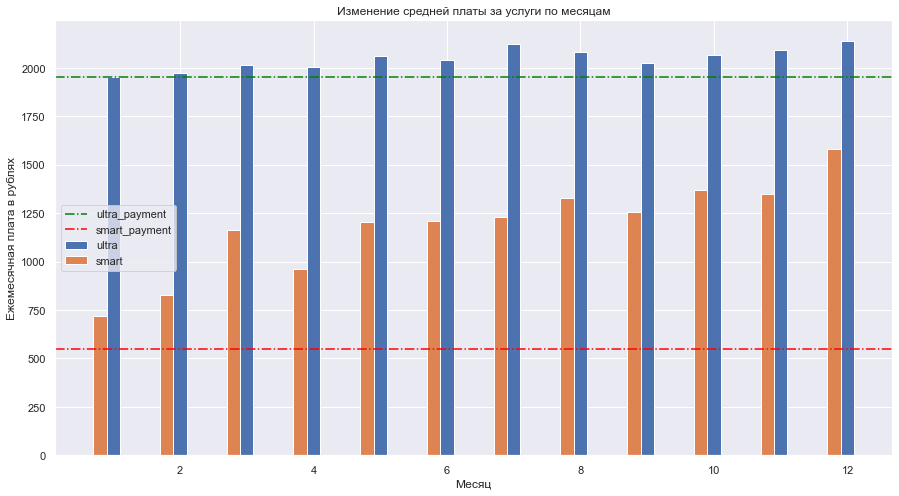

In [68]:
plt.bar(income_by_month_ultra.index, income_by_month_ultra['monthly_income']['mean'], width = 0.2)
plt.bar(income_by_month_smart.index-0.2, income_by_month_smart['monthly_income']['mean'], width = 0.2)
plt.ylabel('Ежемесячная плата в рублях')
plt.xlabel('Месяц')
plt.title('Изменение средней платы за услуги по месяцам')
plt.axhline(1950, color = 'green', linestyle = '-.')
plt.axhline(550, color = 'red', linestyle = '-.')
plt.legend(['ultra_payment', 'smart_payment', 'ultra', 'smart'], loc='left')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [69]:
display(income_by_month_ultra.describe())
display(income_by_month_smart.describe())

monthly_income                                   
                mean  median            var         std
count      12.000000    12.0      12.000000   12.000000
mean     2047.625000  1950.0  111781.436667  300.485833
std        57.221758     0.0   79510.298542  153.107851
min      1950.000000  1950.0       0.000000    0.000000
25%      2011.600000  1950.0   42010.547500  204.905000
50%      2051.505000  1950.0  128591.115000  357.025000
75%      2085.705000  1950.0  169771.522500  412.030000
max      2137.500000  1950.0  231191.550000  480.820000

monthly_income                                        
                mean       median           var          std
count      12.000000    12.000000  1.200000e+01    12.000000
mean     1183.352500   936.875000  5.440748e+05   722.436667
std       240.676522   251.689304  2.275000e+05   155.488274
min       721.320000   550.000000  1.925162e+05   438.770000
25%      1114.237500   819.625000  4.444084e+05   664.037500
50%      1218.915000   972.250000  5.423151e+05   736.420000
75%      1333.702500  1107.250000  6.342628e+05   796.410000
max      1579.630000  1350.000000  1.072930e+06  1035.820000

In [70]:
total_consumption.query('tariff == "ultra"')['monthly_income'].sum()

2041950.0

In [71]:
total_consumption.query('tariff == "smart"')['monthly_income'].sum()

2886301.0

## Вывод

* Пользователи Smart в среднем используют 16200 мегабайт интернета, 417 минут разговоров и 33 сообщения в месяц. Юзеры тарифа Ultra пользуются большим объёмом услуг - 19448 мегабайт интернета, 526 минут разговоров и 49 смс.<br>
* Пользователи тарифа Ultra потребляют больше, чем пользователи Smart, но не настолько больше, во сколько раз лимиты тарифов различаются между собой. Например, пользователи Ultra в среднем отправляют в 1.5 раза больше смс (49 против 33), чем юзеры Smart, притом что тарифные лимиты у них отличаются в 4 раза (200 против 50). Только по потребляемому трафику пользователи Ultra иногда превышают тарифный лимит, в остальном не приближаются к этому даже близко. Пользователи smart же используют тарифные лимиты по полной, часто выходя за их пределы.<br>
* Также заметно, что к концу года траты трафик, звонков и смс у пользователей растут до 2-3 раз, достигая к декабрю максимума. Самый быстрый рост наблюдается в начале года (примерно до марта), потом скорость изменения уменьшается. В тарифе Ultra рост потребления выше и более скачкообразный.<br>
* Распределение у Smart ближе к нормальному, в то время как у Ultra похоже на равномерное - у Smart большая часть значений по минутам и трафику располагается у лимита или немного за ним, в чём прослеживается некоторая рациональность пользоваталей, в то время как в Ultra такого явного пика не прослеживается. Это выражается и в разнице стандартного отклонения - в Ultra оно значительно больше, и сценарии использования лимитов разнообразнее.<br>
* В отношении оплаты у пользователей двух тарифов ситуация зеркальная потреблению услуг - стандартное отклонение в Smart в 4 раза больше, если в Ultra пользователи по разному потребляют, то в Smart по разному платят.

# Проверка гипотез

Посмотрим, различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт»

In [72]:
ultra_income = total_consumption.query('tariff == "ultra"')['monthly_income']
smart_income = total_consumption.query('tariff == "smart"')['monthly_income']

In [73]:
ultra_income.var()

143360.42925834784

In [74]:
smart_income.var()

673877.6236139194

Разница в средней выручке уже кажется значительной. Проверим это статистически. Пусть нулевой гипотезой будет равенство средних двух генеральных совокупностей клиентов с тарифом 'Smart' и 'Ultra'. Альтернативной - что, они не равны. p-value будет равен 0.05. Для проверок гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем t-тест. Так как генеральные совокупности у нас с разными параментрами (клиенты со Smart и клиенты с Ultra), то параметр equal_var = False

In [75]:
ultra_income.mean()

2070.943204868154

In [76]:
smart_income.mean()

1294.3053811659192

In [77]:
from scipy import stats as st

results = st.ttest_ind(ultra_income, smart_income, equal_var = False)

print('p-значение: ', results.pvalue)
alpha = 0.05
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else: 
    print("Нулевую гипотезу отвергнуть нельзя")

p-значение:  1.2414049931248708e-246
Отвергаем нулевую гипотезу


In [78]:
#второй способ
from pingouin import ttest
stats = ttest(ultra_income, smart_income, correction='auto')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,36.709767,3208.90246,two-sided,1.241405e-246,"[735.16, 818.12]",1.086139,2.497e+242,1.0


Как видим, нулевая гипотеза опровергается. Этот вывод напрашивается и из других наблюдений - у клиентов этих тарифов слишком разное поведение

Теперь проверим, отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов. Нулевой гипотезой будет, что средняя выручка в Москве и регионах равна. Альтернативная гипотезы - они не равны. Здесь также проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Дисперсия выборок отличается меньше, чем у предыдущих, но отличается, поэтому ставим параметр equal_var = False

In [79]:
moscow_income = total_consumption.query('city == "Москва"')['monthly_income']
regions_income = total_consumption.query('city != "Москва"')['monthly_income']

In [80]:
moscow_income.var()

566183.0292184273

In [81]:
regions_income.var()

656697.9582266762

In [82]:
len(moscow_income)

611

In [83]:
len(regions_income)

2605

In [84]:
moscow_income.mean()

1550.8052373158755

In [85]:
regions_income.mean()

1528.1032629558542

In [86]:
results = st.ttest_ind(moscow_income, regions_income, equal_var = False)

print('p-значение: ', results.pvalue)
alpha = 0.05
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else: 
    print("Нулевую гипотезу отвергнуть нельзя")

p-значение:  0.5086199993481282
Нулевую гипотезу отвергнуть нельзя


In [87]:
stats1 = ttest(moscow_income, regions_income, paired=True)
stats1

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.661233,970.220883,two-sided,0.50862,"[-44.67, 90.08]",0.028388,0.063,0.096769


Опровергнуть нулевую гипотезу не вышло, средняя выручка одинаковая вне зависимости от географии.

## Вывод

Мы смогли определить, что средняя выручка с клиента для более дорогого тарифа Ultra выше, чем у бюджетного Smart. В то же время оказалось, что география не влияет на выручку с клиента в статистически значимой мере.

# Общий вывод

* У нас имелось 5 разных датасета с персональными данными абонентов, их звонками, сообщениями и трафиком, а также условия тарифа<br>
* Некоторые колонки нужно было перевести в int и округлить (например время разговора), даты для агрегации по месяцам мы привели в формат datetime.
* В исходных датасетах пропуски были только 'churn_date' в таблице 'users', которые обусловлены тем, что пользователи ещё пользуются тарифом на момент окончания года - их мы заполнили 31 декабря.
* Приагрегации всех таблиц по месяцам появились новые пропуски в связи с тем, что люди не пользовались этим услугами в тот месяц, что например с смсками объяснимо, что они постепенно заменяются сообщениями в мессенджерах, поэтому было принято решение заполнить пропуски нулями.
* Пользователи Smart в среднем используют 16200 мегабайт интернета, 417 минут разговоров и 33 сообщения в месяц. Юзеры тарифа Ultra пользуются большим объёмом услуг - 19448 мегабайт интернета, 526 минут разговоров и 49 смс.
* Пользователи тарифа Ultra потребляют больше, чем пользователи Smart, но не настолько больше, во сколько раз лимиты тарифов различаются между собой. Например, пользователи Ultra в среднем отправляют в 1.5 раза больше смс (49 против 33), чем юзеры Smart, притом что тарифные лимиты у них отличаются в 4 раза (200 против 50). Только по потребляемому трафику пользователи Ultra иногда превышают тарифный лимит, в остальном не приближаются к этому даже близко. Пользователи smart же используют тарифные лимиты по полной, часто выходя за их пределы.<br>
* Также заметно, что к концу года траты трафик, звонков и смс у пользователей растут до 2-3 раз, достигая к декабрю максимума. Самый быстрый рост наблюдается в начале года (примерно до марта), потом скорость изменения уменьшается. В тарифе Ultra рост потребления выше и более скачкообразный.<br>
* Распределение у Smart ближе к нормальному, в то время как у Ultra похоже на равномерное - у Smart большая часть значений по минутам и трафику располагается у лимита или немного за ним, в чём прослеживается некоторая рациональность пользоваталей, в то время как в Ultra такого явного пика не прослеживается. Это выражается и в разнице стандартного отклонения - в Ultra оно значительно больше, и сценарии использования лимитов разнообразнее.<br>
* Мы смогли определить, что средняя выручка с клиента для более дорогого тарифа Ultra выше, чем у бюджетного Smart. В то же время оказалось, что география не влияет на выручку с клиента в статистически значимой мере. 
* С одной стороны можно сказать, что тариф Ultra выгоднее для оператора - выручки он приносит на 60% больше, чем Smart в пересчёте в месяц на клиента. К тому же, многие пользователи Ultra не используют свой тариф на максимум и создают меньшую нагрузку на сеть, чем могли бы. При отсутствии данных по стоимости для оператора каждой минуты/смс/мегабайта мы можем только предположить, что их обслуживание может обходиться оператору дешевле, это также говорит в пользу этого тарифа. С другой стороны, если смотреть доход со всех пользователей, то более доступный и массовый Smart выигрывает и приносит денег на 41% больше. Также у пользователей Smart есть тенденция к росту расходов - им сильно не хватает своего лимита, в то время как доход с Ultra достаточно стабильный, т.к пакета им хватает с лихвой. Другой вопрос, что подобная переплата в какой-то момент может надоесть клиенту и он уйдёт к конкуренту, так что разумно было бы ввести в тарифную линейку промежуточный тариф между бюджетным Smart и премиальным Ultra